# 가위바위보 image classsification
데이터는 웹캠으로 촬영하여 생성 [Google Teachable machine](https://teachablemachine.withgoogle.com/) 

In [4]:
# PIL 라이브러리가 설치되어 있지 않다면 설치
!pip install pillow   

from PIL import Image
import os, glob
import numpy as np
import matplotlib.pyplot as plt

### 데이터 사이즈 통일

In [5]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
images=glob.glob(image_dir_path + "/*.jpg")

# 파일의 사이즈가 같게 사이즈 변환하여 저장합니다.
target_size=(28,28)
for img in images:
    old_img=Image.open(img)
    new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")

- PIL : 이미지 처리
- os : 파일 열기 등 운영체제에서 제공하는 기능을 수행
- glob : 파일 리스트, 확장자를 포함한 파일 경로 뽑아내기

### 데이터 로드 & 데이터 정규화
1. 이미지 데이터와 라벨 데이터를 담을 행렬 생성
2. 이미지 행렬 영역에 이미지 데이터 복사 및 index 지정
3. 해당 index를 가진 라벨 행렬에 정답(가위, 바위, 보) 지정 
4. 이미지 행렬 value가 0과 1 사이로 나오도록 정규화

In [6]:
def load_data(img_path):
    number_of_data=1200   # 가위바위보 이미지 개수 총합
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (1200, 28, 28, 3)
y_train shape: (1200,)


In [7]:
def load_data_test(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=300   # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_test, y_test)=load_data_test(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_test.shape))

학습데이터(x_test)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


In [8]:
import tensorflow as tf
from tensorflow import keras

### 딥러닝 모델 만들기
- 3개로 classification 하는 모델이기 때문에, 복잡도를 크게 늘리지 않아도 된다고 생각했다. 첫번째 convlution layer에서는 16 feature 로 시작하였다. 
- 이미지 사이즈가 작아서 maxpooling 횟수를 1번만 하였다.
- 3개로 classification 하는 모델이기 때문에, flatten 후에 20으로 줄여주었다.

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16,(3,3), activation ='relu', input_shape=(28,28,3)))
model.add(keras.layers.Conv2D(32,(3,3), activation ='relu'))
model.add(keras.layers.Conv2D(64,(3,3), activation ='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                154900    
_________________________________________________________________
dense_13 (Dense)             (None, 3)                

### 딥러닝 모델 학습하기
1. 준비된 데이터셋을 모델 input format에 맞도록 reshape
2. 모델을 어떻게 학습시킬 것인지 optimizer, loss 방법을 지정
3. 학습 반복 횟수를 지정하고, 학습

In [23]:
x_train_reshaped=x_train_norm.reshape(1200,28,28,3)
x_test_reshaped=x_test_norm.reshape(300,28,28,3)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_reshaped, y_train, epochs=40)

Epoch 1/40
38/38 [==============================] - 0s 2ms/step - loss: 1.0591 - accuracy: 0.4708
Epoch 2/40
38/38 [==============================] - 0s 2ms/step - loss: 0.7370 - accuracy: 0.6633
Epoch 3/40
38/38 [==============================] - 0s 2ms/step - loss: 0.4205 - accuracy: 0.8350
Epoch 4/40
38/38 [==============================] - 0s 2ms/step - loss: 0.2593 - accuracy: 0.9067
Epoch 5/40
38/38 [==============================] - 0s 2ms/step - loss: 0.1379 - accuracy: 0.9567
Epoch 6/40
38/38 [==============================] - 0s 2ms/step - loss: 0.0667 - accuracy: 0.9825
Epoch 7/40
38/38 [==============================] - 0s 2ms/step - loss: 0.0550 - accuracy: 0.9892
Epoch 8/40
38/38 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.9917
Epoch 9/40
38/38 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 0.9983
Epoch 10/40
38/38 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9992
Epoch 11/40
38/38 [

### 학습된 모델 성능 확인하기

In [25]:
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 6.7647 - accuracy: 0.5700
test_loss: 6.764745235443115 
test_accuracy: 0.5699999928474426


### (optional) 예측 실패한 데이터 확인해보기

예측확률분포:[8.6723250e-01 1.3276617e-01 1.3834656e-06]
라벨:2, 예측결과: 0


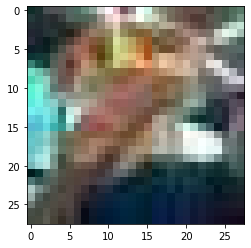

예측확률분포:[1.0114107e-03 9.9898857e-01 1.5303511e-09]
라벨:0, 예측결과: 1


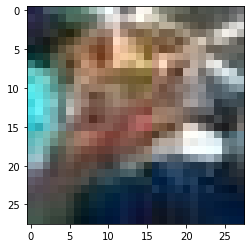

예측확률분포:[0.9303941  0.05900607 0.01059987]
라벨:1, 예측결과: 0


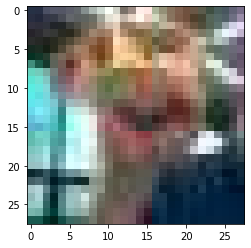

예측확률분포:[9.9251175e-01 7.4883173e-03 8.2214946e-09]
라벨:2, 예측결과: 0


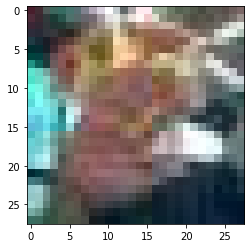

예측확률분포:[9.9540943e-01 4.5905593e-03 2.5116874e-08]
라벨:2, 예측결과: 0


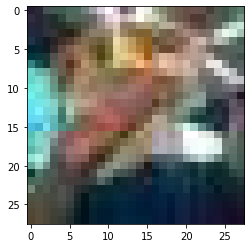

In [26]:
predicted_result = model.predict(x_test_reshaped)
predicted_labels = np.argmax(predicted_result, axis=1)

import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    if predicted_labels[i] !=y_test[i]:
        wrong_predict_list.append(i)
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포:"+str(predicted_result[n]))
    print("라벨:" + str(y_test[n]) + ", 예측결과: " +str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()